<a href="https://colab.research.google.com/github/Guillem96/optc-box-exporter/blob/smart-detection/notebooks/self-supervision-vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 7.6MB 8.3MB/s 


In [ ]:
import json
import random
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torchvision.models as zoo
import torchvision.transforms as T
import torchvision.transforms.functional as F

import tqdm.auto as tqdm

from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading

## Download the data

Download the publicly avaialble dataset from google drive.

We also clone the `optc-box-exporter` repository to download the characters portraits.

In [ ]:
!gdown --id 1IA2Iq5WHMh7vYG-nM2i4YTzqaHbjGBoA
!unzip -q optc.zip
!git clone https://github.com/Guillem96/optc-box-exporter

Downloading...
From: https://drive.google.com/uc?id=1IA2Iq5WHMh7vYG-nM2i4YTzqaHbjGBoA
To: /content/optc.zip
1.44GB [00:08, 164MB/s]
Cloning into 'optc-box-exporter'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 174 (delta 78), reused 139 (delta 51), pack-reused 0
Receiving objects: 100% (174/174), 6.52 MiB | 7.73 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%%shell
cd optc-box-exporter/
python -m optcbx download-portraits \
    --units data/units.json \
    --output data/Portraits

 17% 573/3388 [04:32<22:02,  2.13it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f0574.png
 17% 574/3388 [04:32<21:27,  2.18it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f0575.png
 72% 2438/3388 [22:18<09:49,  1.61it/s]Error while downloading: https://optc-db.github.io/res/character_10643_t1.png
Error while downloading: https://optc-db.github.io/res/character_10644_t1.png
 91% 3072/3388 [28:15<03:02,  1.73it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f3105.png
 91% 3074/3388 [28:16<03:02,  1.72it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f3106.png
 91% 3076/3388 [28:17<02:39,  1.96it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f3108.png
 91% 3077/3388 [28:17<02:12,  2.34it/s]Error while downloading: https://onepiece-treasurecruise.com/wp-content/uploads/f3109.png
 91% 3078/3388 [28:18<02:35,  1.9

In [ ]:
def process_im(base_path, annot_path, out_path):
  crop_path_template = annot_path.stem + '_{}.jpg'
  
  annots = json.load(open(annot_path))
  im = Image.open(base_path / annots['imagePath'])
  boxes = [sum(o['points'], []) for o in annots['shapes']]
  for i, b in enumerate(boxes):
    crop = im.crop(b)
    crop.save(out_path / crop_path_template.format(i))

base_path = Path('/content/screenshots/character-box/')
annots_path = list(base_path.glob('*.json'))
output = Path('data')
output.mkdir(exist_ok=True)

for annot_path in tqdm.tqdm(annots_path):
  process_im(base_path, annot_path, output)

## VAE

In [ ]:
class OPTCDataset(torch.utils.data.Dataset):

  def __init__(self, paths, transforms=None):
    self.paths = paths
    self.transforms = transforms
  
  def __getitem__(self, idx):
    im = Image.open(self.paths[idx]).convert('RGB')

    label = np.array(im.resize((64, 64)))
    label = np.transpose(label, (2, 0, 1))
    label = label.astype('float32') / 255.
    label = torch.as_tensor(label)

    if self.transforms is not None:
      im = self.transforms(im.resize((224, 224)))
    
    return im, label
  
  def __len__(self):
    return len(self.paths)


In [ ]:
!rm -f /content/optc-box-exporter/data/Portraits/5171.png

### Load data

In [ ]:
paths = list(Path('data').glob('*.jpg')) 
paths += list(Path('/content/optc-box-exporter/data/Portraits').glob('*.png'))

train_tfms = T.Compose([
                        T.GaussianBlur(3),
                        T.RandomApply([T.Resize(100)]),
                        T.Resize(224),
                        T.RandomGrayscale(),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

valid_tfms = T.Compose([T.Resize(224),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])
ds = OPTCDataset(paths)
train_ds = OPTCDataset(paths, transforms=train_tfms)
valid_ds = OPTCDataset(paths, transforms=valid_tfms)

ds_len = len(train_ds)
train_ds_len = int(ds_len * .8)
valid_ds_len = ds_len - train_ds_len

rand_idx = torch.randperm(ds_len)
train_ds = torch.utils.data.Subset(train_ds, rand_idx[:train_ds_len])
valid_ds = torch.utils.data.Subset(valid_ds, rand_idx[train_ds_len:])

train_dl = torch.utils.data.DataLoader(
    train_ds, 
    64,
    True,
    pin_memory=True)

valid_dl = torch.utils.data.DataLoader(
    valid_ds, 
    64,
    False,
    pin_memory=True)

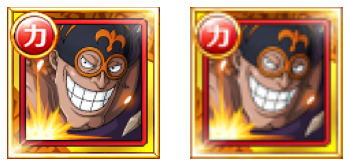

In [ ]:
def show_example(im, label):
  plt.subplot(121)
  plt.imshow(im)
  plt.axis('off')

  plt.subplot(122)
  plt.imshow(F.to_pil_image(label))
  plt.axis('off')

show_example(*ds[random.randint(0, len(ds))])

### Model architecture


In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

from torchvision.models.resnet import BasicBlock

class VAE(nn.Module):
    def __init__(self, image_channels=3, z_dim=32):
        super(VAE, self).__init__()
        
        resnet = zoo.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1], 
                                     Flatten())
        h_dim = resnet.fc.in_features

        # mobilenet_v2 = zoo.mobilenet_v2(pretrained=True)
        # self.encoder = nn.Sequential(*list(mobilenet_v2.children())[:-1], 
        #                              nn.AdaptiveAvgPool2d((1, 1)),
        #                              Flatten())
        # h_dim = mobilenet_v2.last_channel

        self.mu_linear = nn.Linear(h_dim, z_dim)
        self.logvar_linear = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
          nn.BatchNorm2d(128),
          nn.ReLU(),

          nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
          nn.BatchNorm2d(64),
          nn.ReLU(),

          nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.ConvTranspose2d(32, 32, kernel_size=6, stride=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),

          nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
          nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.mu_linear(h), self.logvar_linear(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        # Encoder
        h = self.encoder(x)
        # print(h.size())
        z, mu, logvar = self.bottleneck(h)
        
        # Decoder
        z = self.fc3(z)
        z = z.view(z.size(0), h.size(1), 1, 1)
        return self.decoder(z), mu, logvar

### Training

In [ ]:
BCE_fn = nn.BCELoss(reduction='none')

def loss_fn(pred, y, mu, logvar):
  BCE = BCE_fn(pred, y)
  BCE = BCE.view(y.size(0), -1).sum(-1).mean()

  KLD = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1)
  KLD = 5e-4 * KLD.mean(0)

  return BCE + KLD, (BCE, KLD)


In [ ]:
m = VAE(z_dim=256)
m.to(device);

In [ ]:
epochs = 500

optimizer = torch.optim.SGD(m.parameters(), 1e-4, momentum=.9)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, 1e-2, total_steps=len(train_dl) * epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 150 * len(train_dl))

In [ ]:
for epoch in range(epochs):
  m.train()
  metrics = dict()
  for i, (x, y) in enumerate(train_dl):
    x = x.to(device)
    y = y.to(device)

    preds, mu, logvar = m(x)
    loss, (bce_loss, kld_loss) = loss_fn(preds, y, mu, logvar)

    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(m.parameters(), 5.)
    loss.backward()
    optimizer.step()
    scheduler.step()

    metrics['bce_loss'] = metrics.get('bce_loss', 0.) + bce_loss.item()
    metrics['kld_loss'] = metrics.get('kld_loss', 0.) + kld_loss.item()
    metrics['loss'] = metrics.get('loss', 0.) + loss.item()

    if (i + 1) % 20 == 0:
      means_dict = {k: v / i for k, v in metrics.items()}

      print(f'Epoch[{epoch}] [{i}/{len(train_dl)}]', end=' ')
      print(' '.join([f'{k}: {v:.4f}' for k, v in means_dict.items()]))

  m.eval()
  metrics = dict()
  for x, y in tqdm.tqdm(valid_dl, total=len(valid_dl)):
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      preds, mu, logvar = m(x)
    
    loss, (bce_loss, kld_loss) = loss_fn(preds, y, mu, logvar)
    metrics['bce_loss'] = metrics.get('bce_loss', 0.) + bce_loss.item()
    metrics['kld_loss'] = metrics.get('kld_loss', 0.) + kld_loss.item()
    metrics['loss'] = metrics.get('loss', 0.) + loss.item()

  means_dict = {k: v / len(valid_dl) for k, v in metrics.items()}
  print('Validation', end=' ')
  print(' '.join([f'{k}: {v:.4f}' for k, v in means_dict.items()]))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch[0] [19/61] bce_loss: 6708.5377 kld_loss: 0.5855 loss: 6709.1233
Epoch[0] [39/61] bce_loss: 6551.5017 kld_loss: 0.5720 loss: 6552.0737
Epoch[0] [59/61] bce_loss: 6498.6063 kld_loss: 0.5672 loss: 6499.1735



Validation bce_loss: 6636.3300 kld_loss: 0.5335 loss: 6636.8635
Epoch[1] [19/61] bce_loss: 6733.1288 kld_loss: 0.5863 loss: 6733.7150
Epoch[1] [39/61] bce_loss: 6555.3923 kld_loss: 0.5717 loss: 6555.9640
Epoch[1] [59/61] bce_loss: 6498.2747 kld_loss: 0.5670 loss: 6498.8417



Validation bce_loss: 6638.0644 kld_loss: 0.5336 loss: 6638.5980
Epoch[2] [19/61] bce_loss: 6738.3330 kld_loss: 0.5877 loss: 6738.9207
Epoch[2] [39/61] bce_loss: 6563.3065 kld_loss: 0.5718 loss: 6563.8783
Epoch[2] [59/61] bce_loss: 6498.3160 kld_loss: 0.5667 loss: 6498.8827



Validation bce_loss: 6638.6565 kld_loss: 0.5319 loss: 6639.1884
Epoch[3] [19/61] bce_loss: 6732.0098 kld_loss: 0.5860 loss: 6732.5958
Epoch[3] [39/61] bce_loss: 6555.1631 kld_loss: 0.5716 loss: 6555.7347
Epoch[3] [59/61] bce_loss: 6499.4530 kld_loss: 0.5665 loss: 6500.0195



Validation bce_loss: 6636.3430 kld_loss: 0.5339 loss: 6636.8770
Epoch[4] [19/61] bce_loss: 6716.1288 kld_loss: 0.5865 loss: 6716.7153
Epoch[4] [39/61] bce_loss: 6549.2062 kld_loss: 0.5706 loss: 6549.7768
Epoch[4] [59/61] bce_loss: 6498.7619 kld_loss: 0.5660 loss: 6499.3279



Validation bce_loss: 6637.0813 kld_loss: 0.5334 loss: 6637.6147
Epoch[5] [19/61] bce_loss: 6725.8336 kld_loss: 0.5856 loss: 6726.4192
Epoch[5] [39/61] bce_loss: 6551.0855 kld_loss: 0.5708 loss: 6551.6563
Epoch[5] [59/61] bce_loss: 6497.0617 kld_loss: 0.5660 loss: 6497.6277



Validation bce_loss: 6637.7683 kld_loss: 0.5319 loss: 6638.3002
Epoch[6] [19/61] bce_loss: 6723.4894 kld_loss: 0.5854 loss: 6724.0748
Epoch[6] [39/61] bce_loss: 6549.1082 kld_loss: 0.5700 loss: 6549.6782
Epoch[6] [59/61] bce_loss: 6495.3071 kld_loss: 0.5657 loss: 6495.8729



Validation bce_loss: 6641.5372 kld_loss: 0.5408 loss: 6642.0780
Epoch[7] [19/61] bce_loss: 6729.1800 kld_loss: 0.5874 loss: 6729.7675
Epoch[7] [39/61] bce_loss: 6555.5052 kld_loss: 0.5709 loss: 6556.0761
Epoch[7] [59/61] bce_loss: 6496.6884 kld_loss: 0.5655 loss: 6497.2539



Validation bce_loss: 6638.7901 kld_loss: 0.5305 loss: 6639.3206
Epoch[8] [19/61] bce_loss: 6715.6769 kld_loss: 0.5842 loss: 6716.2611
Epoch[8] [39/61] bce_loss: 6549.1189 kld_loss: 0.5704 loss: 6549.6894
Epoch[8] [59/61] bce_loss: 6495.1762 kld_loss: 0.5655 loss: 6495.7416



Validation bce_loss: 6638.6114 kld_loss: 0.5328 loss: 6639.1442
Epoch[9] [19/61] bce_loss: 6724.2624 kld_loss: 0.5875 loss: 6724.8500
Epoch[9] [39/61] bce_loss: 6549.3538 kld_loss: 0.5706 loss: 6549.9245
Epoch[9] [59/61] bce_loss: 6493.6159 kld_loss: 0.5654 loss: 6494.1812



Validation bce_loss: 6641.3203 kld_loss: 0.5299 loss: 6641.8501
Epoch[10] [19/61] bce_loss: 6724.8810 kld_loss: 0.5859 loss: 6725.4669
Epoch[10] [39/61] bce_loss: 6547.7154 kld_loss: 0.5697 loss: 6548.2852
Epoch[10] [59/61] bce_loss: 6495.6538 kld_loss: 0.5651 loss: 6496.2189



Validation bce_loss: 6638.8863 kld_loss: 0.5298 loss: 6639.4162
Epoch[11] [19/61] bce_loss: 6726.5310 kld_loss: 0.5843 loss: 6727.1153
Epoch[11] [39/61] bce_loss: 6554.7737 kld_loss: 0.5700 loss: 6555.3437
Epoch[11] [59/61] bce_loss: 6495.3455 kld_loss: 0.5648 loss: 6495.9103



Validation bce_loss: 6639.8148 kld_loss: 0.5304 loss: 6640.3452
Epoch[12] [19/61] bce_loss: 6724.8806 kld_loss: 0.5850 loss: 6725.4656
Epoch[12] [39/61] bce_loss: 6552.1332 kld_loss: 0.5693 loss: 6552.7024
Epoch[12] [59/61] bce_loss: 6495.3427 kld_loss: 0.5646 loss: 6495.9073



Validation bce_loss: 6642.6912 kld_loss: 0.5328 loss: 6643.2241
Epoch[13] [19/61] bce_loss: 6715.0795 kld_loss: 0.5838 loss: 6715.6634
Epoch[13] [39/61] bce_loss: 6550.8432 kld_loss: 0.5694 loss: 6551.4126
Epoch[13] [59/61] bce_loss: 6494.9373 kld_loss: 0.5645 loss: 6495.5017



Validation bce_loss: 6640.6069 kld_loss: 0.5296 loss: 6641.1365
Epoch[14] [19/61] bce_loss: 6718.7157 kld_loss: 0.5838 loss: 6719.2995
Epoch[14] [39/61] bce_loss: 6546.3871 kld_loss: 0.5693 loss: 6546.9564
Epoch[14] [59/61] bce_loss: 6493.0584 kld_loss: 0.5645 loss: 6493.6229



Validation bce_loss: 6642.0593 kld_loss: 0.5278 loss: 6642.5871
Epoch[15] [19/61] bce_loss: 6725.3793 kld_loss: 0.5839 loss: 6725.9632
Epoch[15] [39/61] bce_loss: 6549.5923 kld_loss: 0.5693 loss: 6550.1616
Epoch[15] [59/61] bce_loss: 6493.2594 kld_loss: 0.5639 loss: 6493.8233



Validation bce_loss: 6641.3356 kld_loss: 0.5277 loss: 6641.8633
Epoch[16] [19/61] bce_loss: 6734.1125 kld_loss: 0.5846 loss: 6734.6970
Epoch[16] [39/61] bce_loss: 6551.5590 kld_loss: 0.5690 loss: 6552.1279
Epoch[16] [59/61] bce_loss: 6493.9102 kld_loss: 0.5640 loss: 6494.4742



Validation bce_loss: 6642.0906 kld_loss: 0.5274 loss: 6642.6179
Epoch[17] [19/61] bce_loss: 6707.2376 kld_loss: 0.5822 loss: 6707.8198
Epoch[17] [39/61] bce_loss: 6547.2984 kld_loss: 0.5691 loss: 6547.8676
Epoch[17] [59/61] bce_loss: 6492.5595 kld_loss: 0.5637 loss: 6493.1232



Validation bce_loss: 6640.6271 kld_loss: 0.5302 loss: 6641.1573
Epoch[18] [19/61] bce_loss: 6719.1722 kld_loss: 0.5847 loss: 6719.7569
Epoch[18] [39/61] bce_loss: 6551.0797 kld_loss: 0.5693 loss: 6551.6490
Epoch[18] [59/61] bce_loss: 6492.0967 kld_loss: 0.5635 loss: 6492.6602



Validation bce_loss: 6642.0446 kld_loss: 0.5285 loss: 6642.5731
Epoch[19] [19/61] bce_loss: 6721.0074 kld_loss: 0.5844 loss: 6721.5917
Epoch[19] [39/61] bce_loss: 6543.4896 kld_loss: 0.5681 loss: 6544.0576
Epoch[19] [59/61] bce_loss: 6491.8101 kld_loss: 0.5634 loss: 6492.3735



Validation bce_loss: 6641.9799 kld_loss: 0.5278 loss: 6642.5077
Epoch[20] [19/61] bce_loss: 6720.2861 kld_loss: 0.5821 loss: 6720.8683
Epoch[20] [39/61] bce_loss: 6549.7642 kld_loss: 0.5678 loss: 6550.3320
Epoch[20] [59/61] bce_loss: 6494.5611 kld_loss: 0.5630 loss: 6495.1241



Validation bce_loss: 6643.2373 kld_loss: 0.5274 loss: 6643.7647
Epoch[21] [19/61] bce_loss: 6731.7849 kld_loss: 0.5834 loss: 6732.3684
Epoch[21] [39/61] bce_loss: 6550.5745 kld_loss: 0.5675 loss: 6551.1419
Epoch[21] [59/61] bce_loss: 6492.0055 kld_loss: 0.5629 loss: 6492.5684



Validation bce_loss: 6641.7559 kld_loss: 0.5299 loss: 6642.2858
Epoch[22] [19/61] bce_loss: 6726.9174 kld_loss: 0.5831 loss: 6727.5005
Epoch[22] [39/61] bce_loss: 6547.7841 kld_loss: 0.5678 loss: 6548.3519
Epoch[22] [59/61] bce_loss: 6491.7590 kld_loss: 0.5627 loss: 6492.3217



Validation bce_loss: 6643.4231 kld_loss: 0.5290 loss: 6643.9521
Epoch[23] [19/61] bce_loss: 6721.2878 kld_loss: 0.5820 loss: 6721.8699
Epoch[23] [39/61] bce_loss: 6548.4128 kld_loss: 0.5673 loss: 6548.9801
Epoch[23] [59/61] bce_loss: 6492.5759 kld_loss: 0.5625 loss: 6493.1384



Validation bce_loss: 6643.3855 kld_loss: 0.5248 loss: 6643.9104
Epoch[24] [19/61] bce_loss: 6722.2487 kld_loss: 0.5837 loss: 6722.8324
Epoch[24] [39/61] bce_loss: 6547.6454 kld_loss: 0.5677 loss: 6548.2131
Epoch[24] [59/61] bce_loss: 6493.6786 kld_loss: 0.5625 loss: 6494.2411



Validation bce_loss: 6641.6054 kld_loss: 0.5266 loss: 6642.1320
Epoch[25] [19/61] bce_loss: 6713.2953 kld_loss: 0.5816 loss: 6713.8769
Epoch[25] [39/61] bce_loss: 6544.0879 kld_loss: 0.5663 loss: 6544.6542
Epoch[25] [59/61] bce_loss: 6492.0397 kld_loss: 0.5620 loss: 6492.6017



Validation bce_loss: 6642.8461 kld_loss: 0.5273 loss: 6643.3734
Epoch[26] [19/61] bce_loss: 6711.4909 kld_loss: 0.5811 loss: 6712.0720
Epoch[26] [39/61] bce_loss: 6548.6969 kld_loss: 0.5669 loss: 6549.2638
Epoch[26] [59/61] bce_loss: 6493.1180 kld_loss: 0.5619 loss: 6493.6798



Validation bce_loss: 6641.2496 kld_loss: 0.5301 loss: 6641.7797
Epoch[27] [19/61] bce_loss: 6708.8549 kld_loss: 0.5814 loss: 6709.4363
Epoch[27] [39/61] bce_loss: 6541.8668 kld_loss: 0.5662 loss: 6542.4330
Epoch[27] [59/61] bce_loss: 6491.5479 kld_loss: 0.5617 loss: 6492.1096



Validation bce_loss: 6644.5598 kld_loss: 0.5264 loss: 6645.0862
Epoch[28] [19/61] bce_loss: 6714.2943 kld_loss: 0.5809 loss: 6714.8751
Epoch[28] [39/61] bce_loss: 6540.6469 kld_loss: 0.5663 loss: 6541.2132
Epoch[28] [59/61] bce_loss: 6490.9496 kld_loss: 0.5615 loss: 6491.5110



Validation bce_loss: 6644.9020 kld_loss: 0.5266 loss: 6645.4286
Epoch[29] [19/61] bce_loss: 6711.5151 kld_loss: 0.5805 loss: 6712.0956
Epoch[29] [39/61] bce_loss: 6542.1893 kld_loss: 0.5654 loss: 6542.7547
Epoch[29] [59/61] bce_loss: 6491.4929 kld_loss: 0.5609 loss: 6492.0538



Validation bce_loss: 6643.1397 kld_loss: 0.5284 loss: 6643.6681
Epoch[30] [19/61] bce_loss: 6712.8041 kld_loss: 0.5795 loss: 6713.3836
Epoch[30] [39/61] bce_loss: 6545.2676 kld_loss: 0.5653 loss: 6545.8329
Epoch[30] [59/61] bce_loss: 6491.2922 kld_loss: 0.5609 loss: 6491.8532



Validation bce_loss: 6649.0498 kld_loss: 0.5258 loss: 6649.5756
Epoch[31] [19/61] bce_loss: 6724.3640 kld_loss: 0.5803 loss: 6724.9444
Epoch[31] [39/61] bce_loss: 6548.5175 kld_loss: 0.5655 loss: 6549.0830
Epoch[31] [59/61] bce_loss: 6491.2548 kld_loss: 0.5607 loss: 6491.8155



Validation bce_loss: 6642.9714 kld_loss: 0.5249 loss: 6643.4963
Epoch[32] [19/61] bce_loss: 6725.4747 kld_loss: 0.5816 loss: 6726.0562
Epoch[32] [39/61] bce_loss: 6551.1793 kld_loss: 0.5663 loss: 6551.7455
Epoch[32] [59/61] bce_loss: 6489.7498 kld_loss: 0.5607 loss: 6490.3104



Validation bce_loss: 6645.3109 kld_loss: 0.5263 loss: 6645.8372
Epoch[33] [19/61] bce_loss: 6713.5131 kld_loss: 0.5805 loss: 6714.0936
Epoch[33] [39/61] bce_loss: 6540.4128 kld_loss: 0.5655 loss: 6540.9783
Epoch[33] [59/61] bce_loss: 6492.8274 kld_loss: 0.5603 loss: 6493.3877



Validation bce_loss: 6642.2658 kld_loss: 0.5281 loss: 6642.7940
Epoch[34] [19/61] bce_loss: 6710.7416 kld_loss: 0.5800 loss: 6711.3216
Epoch[34] [39/61] bce_loss: 6551.6933 kld_loss: 0.5650 loss: 6552.2583
Epoch[34] [59/61] bce_loss: 6490.1003 kld_loss: 0.5600 loss: 6490.6604



Validation bce_loss: 6647.0578 kld_loss: 0.5245 loss: 6647.5823
Epoch[35] [19/61] bce_loss: 6726.1206 kld_loss: 0.5797 loss: 6726.7003
Epoch[35] [39/61] bce_loss: 6549.0818 kld_loss: 0.5644 loss: 6549.6462
Epoch[35] [59/61] bce_loss: 6491.3074 kld_loss: 0.5597 loss: 6491.8671



Validation bce_loss: 6644.9498 kld_loss: 0.5246 loss: 6645.4745
Epoch[36] [19/61] bce_loss: 6724.7171 kld_loss: 0.5787 loss: 6725.2958
Epoch[36] [39/61] bce_loss: 6546.7365 kld_loss: 0.5647 loss: 6547.3012
Epoch[36] [59/61] bce_loss: 6490.9984 kld_loss: 0.5597 loss: 6491.5580



Validation bce_loss: 6644.5393 kld_loss: 0.5257 loss: 6645.0650
Epoch[37] [19/61] bce_loss: 6715.1155 kld_loss: 0.5798 loss: 6715.6953
Epoch[37] [39/61] bce_loss: 6547.5751 kld_loss: 0.5645 loss: 6548.1395
Epoch[37] [59/61] bce_loss: 6490.3684 kld_loss: 0.5596 loss: 6490.9279



Validation bce_loss: 6645.9703 kld_loss: 0.5253 loss: 6646.4957
Epoch[38] [19/61] bce_loss: 6706.2759 kld_loss: 0.5786 loss: 6706.8545
Epoch[38] [39/61] bce_loss: 6543.1561 kld_loss: 0.5641 loss: 6543.7202
Epoch[38] [59/61] bce_loss: 6489.9426 kld_loss: 0.5594 loss: 6490.5020



Validation bce_loss: 6645.3138 kld_loss: 0.5249 loss: 6645.8387
Epoch[39] [19/61] bce_loss: 6714.1121 kld_loss: 0.5793 loss: 6714.6913
Epoch[39] [39/61] bce_loss: 6534.9762 kld_loss: 0.5638 loss: 6535.5399
Epoch[39] [59/61] bce_loss: 6490.3623 kld_loss: 0.5592 loss: 6490.9215



Validation bce_loss: 6644.6629 kld_loss: 0.5289 loss: 6645.1917
Epoch[40] [19/61] bce_loss: 6709.0869 kld_loss: 0.5788 loss: 6709.6657
Epoch[40] [39/61] bce_loss: 6542.2701 kld_loss: 0.5640 loss: 6542.8341
Epoch[40] [59/61] bce_loss: 6490.1695 kld_loss: 0.5587 loss: 6490.7283



Validation bce_loss: 6644.0883 kld_loss: 0.5270 loss: 6644.6153
Epoch[41] [19/61] bce_loss: 6712.4419 kld_loss: 0.5757 loss: 6713.0176
Epoch[41] [39/61] bce_loss: 6539.9542 kld_loss: 0.5628 loss: 6540.5170
Epoch[41] [59/61] bce_loss: 6487.6969 kld_loss: 0.5585 loss: 6488.2554



Validation bce_loss: 6645.3645 kld_loss: 0.5280 loss: 6645.8925
Epoch[42] [19/61] bce_loss: 6719.2639 kld_loss: 0.5790 loss: 6719.8429


KeyboardInterrupt: ignored

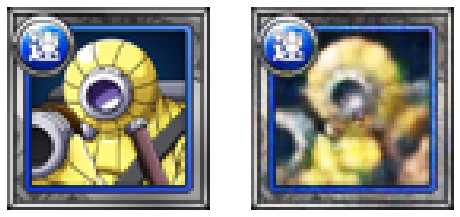

In [ ]:
m.eval()
with torch.no_grad():
  x, y = valid_ds[random.randint(0, len(valid_ds))]
  preds = m(x.unsqueeze(0).to(device))[0][0].cpu()

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.imshow(y.permute(1, 2, 0))
plt.axis('off')

plt.subplot(122)
plt.imshow(preds.permute(1, 2, 0))
plt.axis('off')

plt.show()

In [ ]:
torch.save(m.encoder.state_dict(), 'enc-checkpoint.pt')
torch.save(m.state_dict(), 'checkpoint.pt')